# Sub-fase 4.2: Formalización del Marco Matemático (ULTRA)

In [56]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import glob
from scipy.stats import pearsonr, spearmanr

# Style and Seed
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Paths
FIGURES_DIR = "phase4_figures"
TABLES_DIR = "phase4_tables"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

# Inputs
PHASE3_CSV = "../../data/phase3/phase3_results.csv"
ANCHORS_CSV = "../../data/phase3/artifacts/embeddings_anchors.csv"
ARTIFACTS_DIR = "../../data/phase3/artifacts"
DIMENSIONS_JSON = "../../data/dimensiones_ancla.json"

print("Setup Complete. SEED=42.")


Setup Complete. SEED=42.


In [57]:

# Load Data
try:
    df = pd.read_csv(PHASE3_CSV)
    df['window_end_month'] = pd.to_datetime(df['window_end_month'])
    df.sort_values('window_end_month', inplace=True)
    print(f"Loaded Phase 3 Results: {len(df)} rows")
except Exception as e:
    print(f"CRITICAL FAIL: Could not load {PHASE3_CSV}")
    raise e

# Helpers
variants = ["baseline"]
if any("dapt" in c for c in df.columns):
    variants.append("dapt")
strategies = ["penultimate", "last4_concat"]

print(f"Variants: {variants}")
print(f"Strategies: {strategies}")


Loaded Phase 3 Results: 42 rows
Variants: ['baseline', 'dapt']
Strategies: ['penultimate', 'last4_concat']


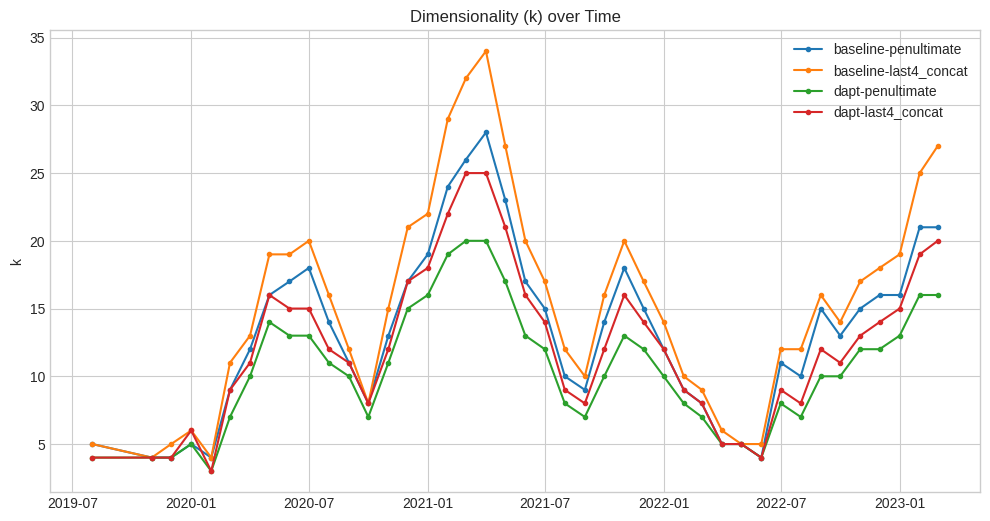

Correlation k vs n_occurrences (baseline): 0.970
Correlation k vs n_occurrences (dapt): 0.952


In [58]:

# --- 1. K Profile (Dimensionality) ---

k_stats_list = []

# A. K Distribution & Stability
plt.figure(figsize=(12, 6))

for v in variants:
    for s in strategies:
        col = f"k_{v}_{s}"
        if col in df.columns:
            # Stats
            desc = df[col].describe()
            # Stability: Delta K
            delta_k = df[col].diff().abs()
            unstable_wins = (delta_k >= 3).sum()
            
            k_stats_list.append({
                "variant": v, 
                "strategy": s,
                "mean": desc['mean'], 
                "std": desc['std'],
                "min": desc['min'], 
                "max": desc['max'],
                "iqr": desc['75%'] - desc['25%'],
                "unstable_windows_delta_ge_3": unstable_wins
            })
            
            plt.plot(df['window_end_month'], df[col], marker='.', label=f"{v}-{s}")

plt.title('Dimensionality (k) over Time')
plt.ylabel('k')
plt.legend()
plt.savefig(f"{FIGURES_DIR}/42_k_over_time.png")
plt.show()

pd.DataFrame(k_stats_list).to_csv(f"{TABLES_DIR}/42_k_profile.csv", index=False)

# B. K vs n_occurrences (Sensitivity)
# Check correlation
for v in variants:
    # Use one strategy for clarity, e.g., penultimate
    col = f"k_{v}_penultimate"
    if col in df.columns:
        corr, _ = pearsonr(df['n_occurrences'], df[col])
        print(f"Correlation k vs n_occurrences ({v}): {corr:.3f}")


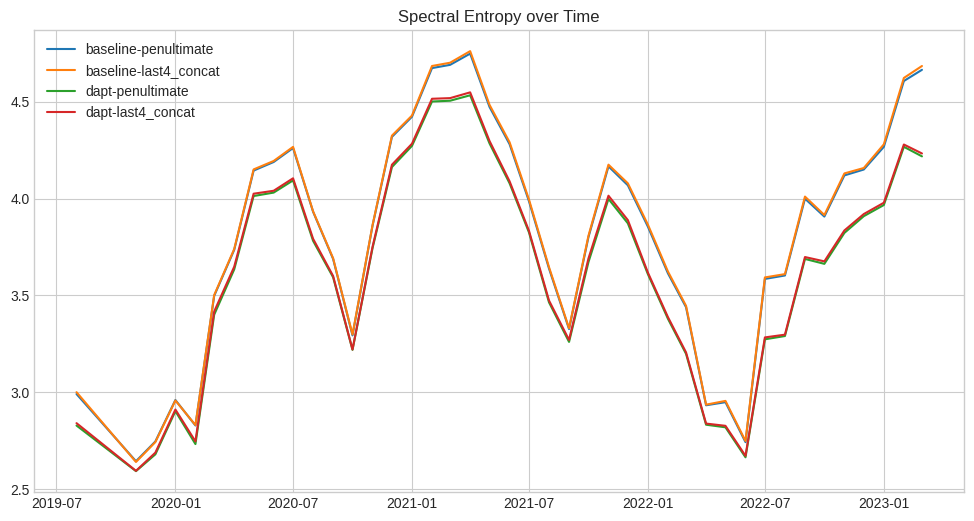

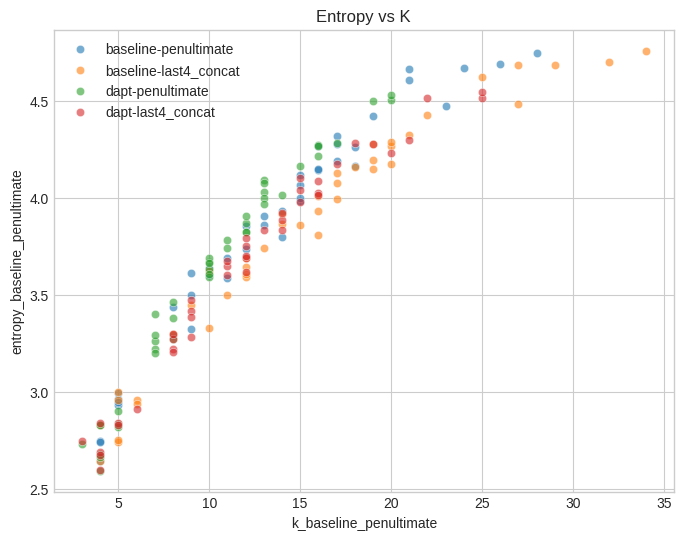

In [59]:

# --- 2. Entropy Analysis ---

ent_stats_list = []
ent_k_corr_list = []

# A. Entropy over Time
plt.figure(figsize=(12, 6))
for v in variants:
    for s in strategies:
        col = f"entropy_{v}_{s}"
        if col in df.columns:
            # Stats
            desc = df[col].describe()
            ent_stats_list.append({
                "variant": v, "strategy": s,
                "mean": desc['mean'], "std": desc['std']
            })
            plt.plot(df['window_end_month'], df[col], label=f"{v}-{s}")
plt.title('Spectral Entropy over Time')
plt.legend()
plt.savefig(f"{FIGURES_DIR}/42_entropy_over_time.png")
plt.show()

pd.DataFrame(ent_stats_list).to_csv(f"{TABLES_DIR}/42_entropy_profile.csv", index=False)

# B. Entropy vs K (Scatter & Correlation)
plt.figure(figsize=(8, 6))
for v in variants:
    for s in strategies:
        k_col = f"k_{v}_{s}"
        e_col = f"entropy_{v}_{s}"
        if k_col in df.columns and e_col in df.columns:
            sns.scatterplot(data=df, x=k_col, y=e_col, label=f"{v}-{s}", alpha=0.6)
            
            sub = df[[k_col, e_col]].dropna()
            corr_p, _ = pearsonr(sub[k_col], sub[e_col])
            corr_s, _ = spearmanr(sub[k_col], sub[e_col])
            
            ent_k_corr_list.append({
                "variant": v, "strategy": s,
                "pearson": corr_p, "spearman": corr_s
            })
plt.title('Entropy vs K')
plt.legend()
plt.savefig(f"{FIGURES_DIR}/42_entropy_vs_k.png")
plt.show()

pd.DataFrame(ent_k_corr_list).to_csv(f"{TABLES_DIR}/42_entropy_vs_k.csv", index=False)

# Sensitivity check
# entropy vs n_occurrences scatter?


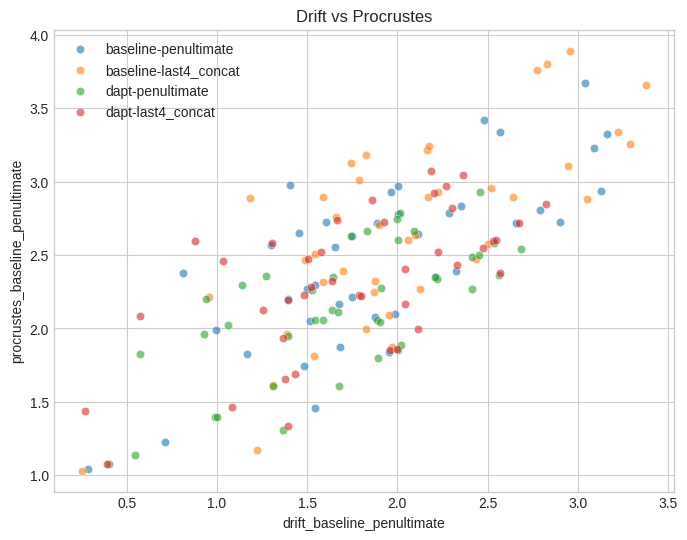

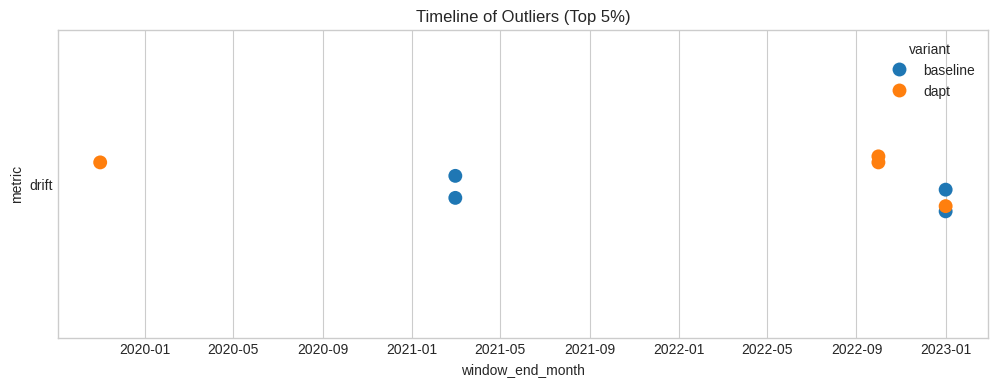

In [60]:

# --- 3. Drift & Procrustes (Detailed) ---

dp_profile = []
outliers_list = []

# A. Timelines
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for v in variants:
    for s in strategies:
        d_col = f"drift_{v}_{s}"
        p_col = f"procrustes_{v}_{s}"
        
        if d_col in df.columns:
            ax[0].plot(df['window_end_month'], df[d_col], label=f"{v}-{s}")
            
            # Outlier detection (95th percentile)
            lim_d = df[d_col].quantile(0.95)
            outs = df[df[d_col] > lim_d].copy()
            if not outs.empty:
                outs['metric'] = 'drift'
                outs['variant'] = v
                outs['strategy'] = s
                outs['value'] = outs[d_col]
                outliers_list.append(outs[['window_end_month', 'metric', 'variant', 'strategy', 'value']])

        if p_col in df.columns:
            ax[1].plot(df['window_end_month'], df[p_col], label=f"{v}-{s}")

ax[0].set_title('Drift (Grassmann)')
ax[0].legend()
ax[1].set_title('Procrustes Error')
ax[1].legend()
plt.savefig(f"{FIGURES_DIR}/42_drift_over_time.png") # Saving combined plot logic to separate names?
# User asked for separate or combined? List has: 42_drift_over_time.png, 42_procrustes_over_time.png
# Let's save separately too
plt.close()

# Separate Plots
plt.figure(figsize=(10, 5))
for v in variants:
    for s in strategies:
        if f"drift_{v}_{s}" in df.columns: plt.plot(df['window_end_month'], df[f"drift_{v}_{s}"], label=f"{v}-{s}")
plt.title("Drift over Time")
plt.legend()
plt.savefig(f"{FIGURES_DIR}/42_drift_over_time.png")
plt.close()

plt.figure(figsize=(10, 5))
for v in variants:
    for s in strategies:
        if f"procrustes_{v}_{s}" in df.columns: plt.plot(df['window_end_month'], df[f"procrustes_{v}_{s}"], label=f"{v}-{s}")
plt.title("Procrustes over Time")
plt.legend()
plt.savefig(f"{FIGURES_DIR}/42_procrustes_over_time.png")
plt.close()

# B. Drift vs Procrustes
plt.figure(figsize=(8, 6))
for v in variants:
    for s in strategies:
        d_col = f"drift_{v}_{s}"
        p_col = f"procrustes_{v}_{s}"
        if d_col in df.columns and p_col in df.columns:
            sns.scatterplot(data=df, x=d_col, y=p_col, label=f"{v}-{s}", alpha=0.6)
            
            sub = df[[d_col, p_col]].dropna()
            if len(sub) > 2:
                corr, _ = pearsonr(sub[d_col], sub[p_col])
                dp_profile.append({
                    "variant": v, "strategy": s,
                    "corr_drift_procrustes": corr,
                    "mean_drift": sub[d_col].mean(),
                    "mean_procrustes": sub[p_col].mean()
                })

plt.title('Drift vs Procrustes')
plt.savefig(f"{FIGURES_DIR}/42_drift_vs_procrustes.png")
plt.show()

# C. Outliers Timeline
if outliers_list:
    outlier_df = pd.concat(outliers_list)
    outlier_df.to_csv(f"{TABLES_DIR}/42_outlier_windows.csv", index=False)
    
    # Plot timeline of outliers
    plt.figure(figsize=(12, 4))
    sns.stripplot(data=outlier_df, x='window_end_month', y='metric', hue='variant', jitter=True, size=10)
    plt.title('Timeline of Outliers (Top 5%)')
    plt.savefig(f"{FIGURES_DIR}/42_outliers_timeline.png")
    plt.show()

pd.DataFrame(dp_profile).to_csv(f"{TABLES_DIR}/42_drift_procrustes_profile.csv", index=False)


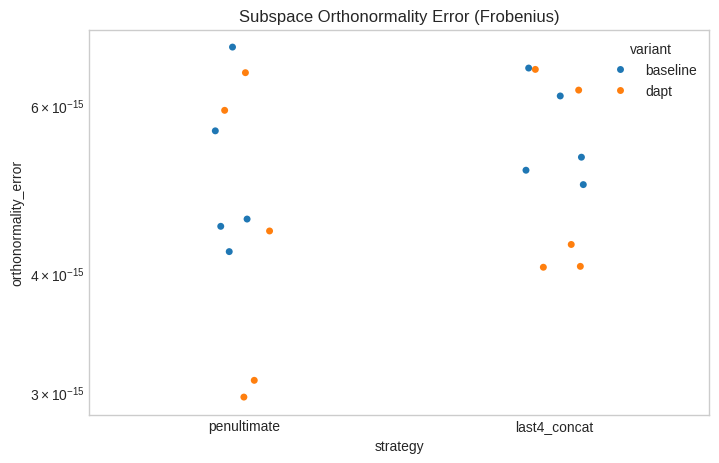

In [61]:

# --- 4. Geometría de Subespacios (Checks) ---

subspace_checks = []

# Randomly sample windows to check (or check all if manageable)
# Check 5 random windows per combination
sample_df = df.sample(min(5, len(df)))

for _, row in sample_df.iterrows():
    win_date = row['window_end_month'].strftime("%Y-%m")
    
    for v in variants:
        for s in strategies:
            # Construct path
            # Expected: window_YYYY-MM_variant_strategy.npz in artifacts/subspaces/
            # Or root artifacts dir
            fname = f"window_{win_date}_{v}_{s}.npz"
            paths = [
                f"{ARTIFACTS_DIR}/subspaces/{fname}",
                f"{ARTIFACTS_DIR}/{fname}"
            ]
            found = False
            for p in paths:
                if os.path.exists(p):
                    found = True
                    try:
                        data = np.load(p)
                        U = data['U']
                        # Check Orthonormality
                        UTU = U.T @ U
                        I = np.eye(UTU.shape[0])
                        err = np.linalg.norm(UTU - I, ord='fro')
                        
                        subspace_checks.append({
                            "window": win_date,
                            "variant": v,
                            "strategy": s,
                            "U_shape": str(U.shape),
                            "orthonormality_error": err,
                            "status": "PASS" if err < 1e-4 else "WARNING"
                        })
                    except Exception as e:
                        subspace_checks.append({"window": win_date, "variant": v, "status": "FAIL", "error": str(e)})
                    break
            if not found:
                pass # Silent skip if not found? Or mark missing?
                # subspace_checks.append({"window": win_date, "variant": v, "status": "MISSING"})

if subspace_checks:
    checks_df = pd.DataFrame(subspace_checks)
    checks_df.to_csv(f"{TABLES_DIR}/42_subspace_geometry_checks.csv", index=False)
    
    # Plot error
    plt.figure(figsize=(8, 5))
    sns.stripplot(data=checks_df, x='strategy', y='orthonormality_error', hue='variant')
    plt.title('Subspace Orthonormality Error (Frobenius)')
    plt.yscale('log')
    plt.savefig(f"{FIGURES_DIR}/42_subspace_orthonormality.png")
    plt.show()
else:
    print("No subspace .npz files found to check.")


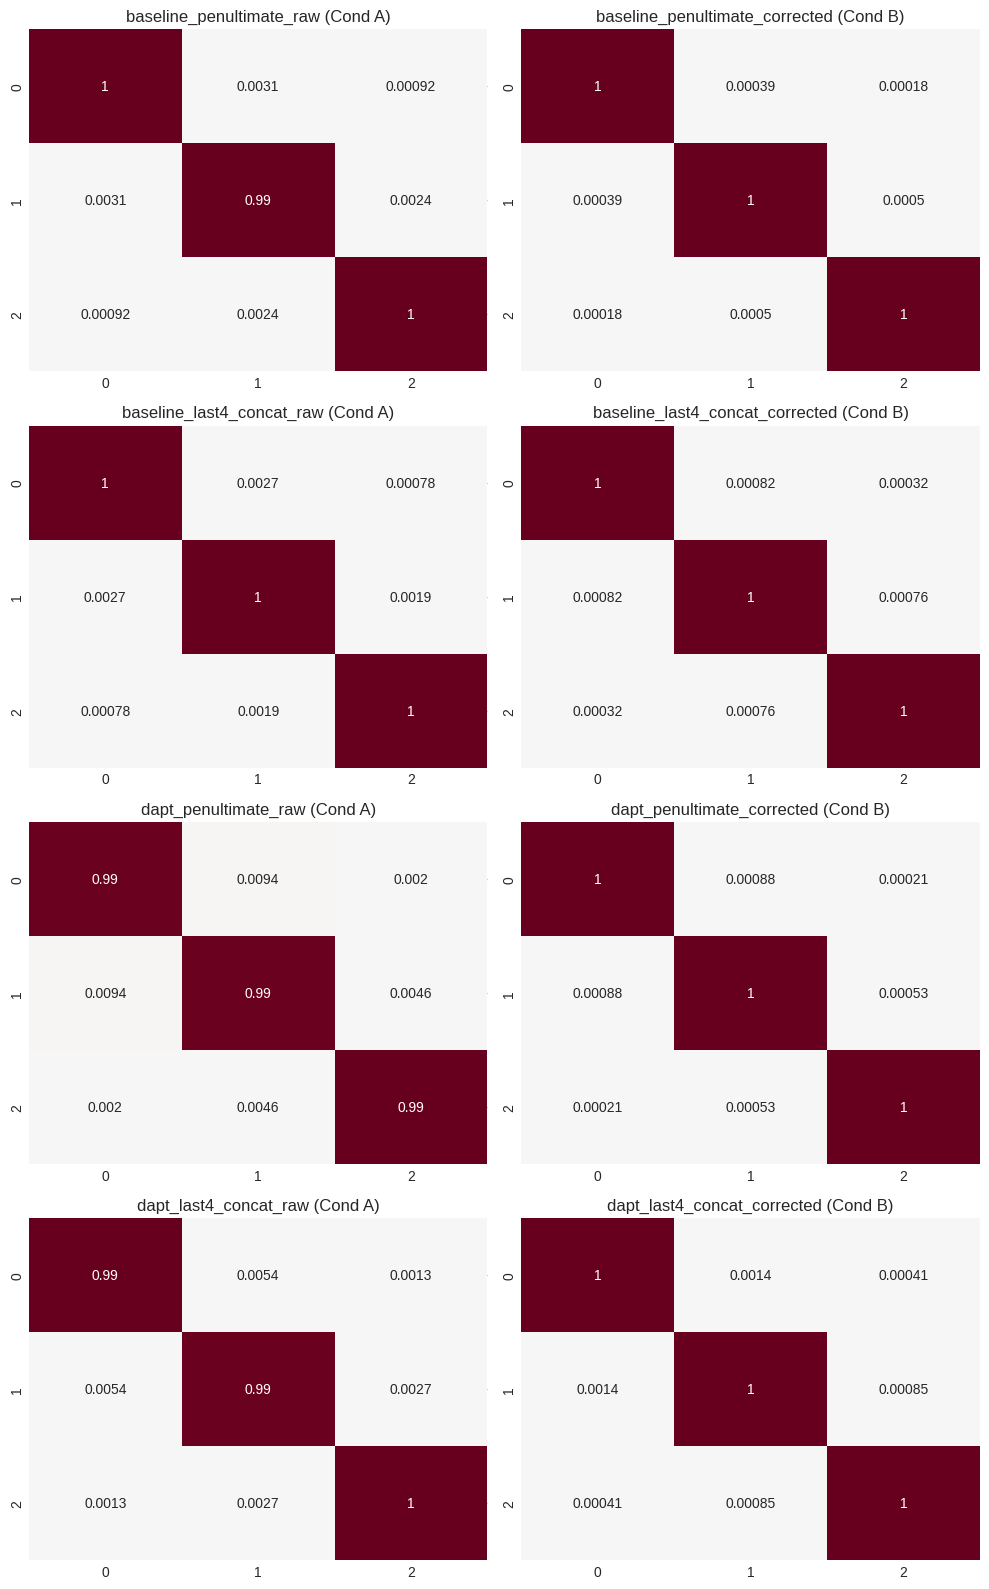

In [62]:

# --- 5. Geometría de Anclas (Comparativa A/B) ---

anchor_checks = []
anchor_matrices = {} # Key: "{v}_{s}_{cond}"

conditions = ["raw", "corrected"]

for v in variants:
    for s in strategies:
        for cond in conditions:
            # File naming: anchors_{v}_{s}_{cond}.npz
            # (Note: dual_anisotropy_update.py saved them with suffixes _raw and _corrected)
            fname = f"anchors_{v}_{s}_{cond}.npz"
            paths = [
                f"{ARTIFACTS_DIR}/anchors/{fname}",
                f"{ARTIFACTS_DIR}/{fname}"
            ]
            
            found = False
            for p in paths:
                if os.path.exists(p):
                    found = True
                    try:
                        data = np.load(p)
                        A = data['A']
                        key = f"{v}_{s}_{cond}"
                        anchor_matrices[key] = A
                        
                        # Orthogonality
                        ATA = A.T @ A
                        I = np.eye(ATA.shape[0])
                        err = np.linalg.norm(ATA - I, ord='fro')
                        
                        # Off-diagonals (Max Cosine)
                        off_diag = ATA - np.diag(np.diag(ATA))
                        max_cos = np.max(np.abs(off_diag))
                        
                        anchor_checks.append({
                            "variant": v,
                            "strategy": s,
                            "condition": cond,
                            "orthogonality_error": err,
                            "max_cosine": max_cos
                        })
                        
                    except Exception as e:
                        print(f"Error loading {fname}: {e}")
                    break

pd.DataFrame(anchor_checks).to_csv(f"{TABLES_DIR}/42_anchor_geometry_checks_dual.csv", index=False)

# Visualizing Orthogonality (Heatmaps Side-by-Side)
keys = sorted(anchor_matrices.keys())
n = len(keys)
if n > 0:
    rows = len(variants) * len(strategies)
    cols = 2 # Raw vs Corrected
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4*rows))
    axes = axes.flatten()
    
    idx = 0
    for v in variants:
        for s in strategies:
            # Plot Raw
            k_raw = f"{v}_{s}_raw"
            ax_raw = axes[idx]
            if k_raw in anchor_matrices:
                 A = anchor_matrices[k_raw]
                 sns.heatmap(A.T @ A, annot=True, center=0, ax=ax_raw, cbar=False, cmap="RdBu_r", vmin=-1, vmax=1)
                 ax_raw.set_title(f"{k_raw} (Cond A)")
            idx += 1
            
            # Plot Corrected
            k_corr = f"{v}_{s}_corrected"
            ax_corr = axes[idx]
            if k_corr in anchor_matrices:
                 A = anchor_matrices[k_corr]
                 sns.heatmap(A.T @ A, annot=True, center=0, ax=ax_corr, cbar=False, cmap="RdBu_r", vmin=-1, vmax=1)
                 ax_corr.set_title(f"{k_corr} (Cond B)")
            idx += 1
            
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/42_anchor_orthogonality_dual.png")
    plt.show()
    

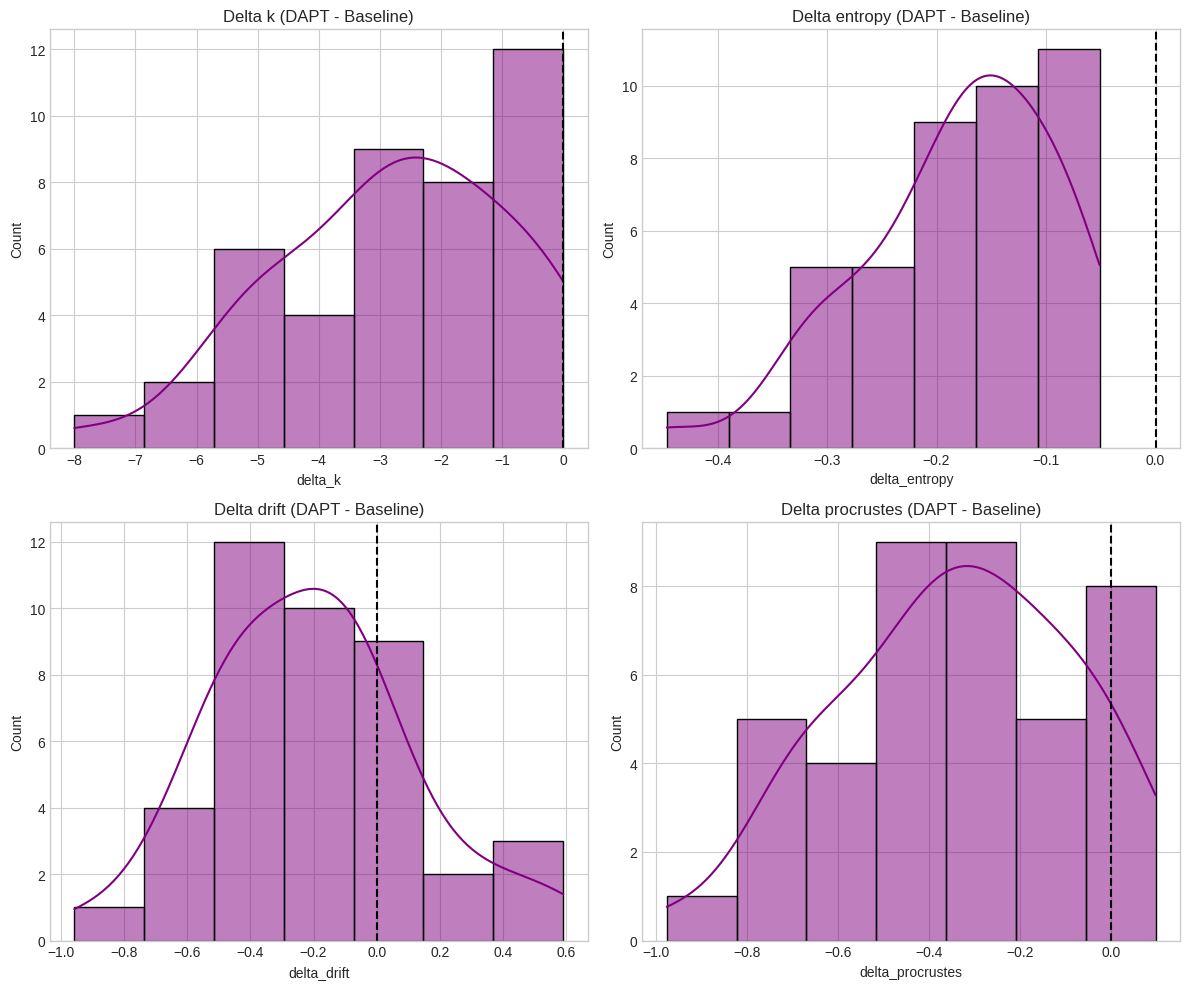

In [63]:

# --- 6. Baseline vs DAPT (Comparative Math) ---

if "dapt" in variants:
    # Deltas
    metrics = ['k', 'entropy', 'drift', 'procrustes']
    s = 'penultimate'
    
    deltas_list = []
    
    # Fig setup
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, m in enumerate(metrics):
        col_b = f"{m}_baseline_{s}"
        col_d = f"{m}_dapt_{s}"
        
        if col_b in df.columns and col_d in df.columns:
            # Calc delta
            df[f"delta_{m}"] = df[col_d] - df[col_b] # DAPT - Baseline
            
            # Plot
            sns.histplot(df[f"delta_{m}"], kde=True, ax=axes[i], color='purple')
            axes[i].set_title(f"Delta {m} (DAPT - Baseline)")
            axes[i].axvline(0, color='k', linestyle='--')
            
            # Test (Wilcoxon)
            from scipy.stats import wilcoxon
            # Dropna
            valid = df[[col_b, col_d]].dropna()
            stat, pval = wilcoxon(valid[col_b], valid[col_d])
            
            deltas_list.append({
                "metric": m,
                "strategy": s,
                "mean_delta": df[f"delta_{m}"].mean(),
                "wilcoxon_stat": stat,
                "p_value": pval,
                "significant": pval < 0.05
            })
            
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/42_baseline_vs_dapt_math.png")
    plt.show()
    
    pd.DataFrame(deltas_list).to_csv(f"{TABLES_DIR}/42_baseline_vs_dapt_math.csv", index=False)
else:
    print("DAPT not present, skipping comparison.")
